# Mapping Emotions Between Music and Lyrics

In this project we are explore the alignment of emotions between music and lyrics. 

To this end we are leveraging `MuLan embeddings`, a joint audio-language embedding model. By mapping music audio and natural language descriptions into a shared embedding space, MuLan enables us to capture semantic and emotional similarities across modalities. Our aim is to analyze and visualize the emotional alignment between music and lyrics.

# Initial Setup

Here we will setup basic dependencies for our project. Like enviorment file reading library loading etc 

In [103]:
# from acrcloud.recognizer import ACRCloudRecognizer
import os
import numpy as np
from dotenv import load_dotenv
from Meta_Data_Collection import MetaDataCollection 
from Meta_Data_Collection_AudD import AudDMetaDataCollection
import pandas as pd
from Lyrics_Extraction import LyricsExtractor
import time 
from lyrics_preprocessing import process_lyrics_folder
from get_embeddings import extract_audio_embeddings, extract_text_embeddings, load_audio_embeddings, load_lyrics_embeddings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import torch
import torchaudio
import librosa

load_dotenv()

True

# Data Collection

For our data we are using a combination of the [DEAM dataset](https://cvml.unige.ch/databases/DEAM/) for audio and [LyricWiki](https://pypi.org/project/lyricwikia/) for the lyrics. 

- DEAM contains over 1,800 songs with annotations for dynamic and continuous emotion labels (valence and arousal) at the level of short segments. 

- While it does not contain raw audio data, LyricWiki and Musixmatch add lyric annotations for semantic and sentiment analysis.

## Getting Audio Meta-data

Altought DEAM contains the raw audio files with annotations, it however does not contain structured meta-data (Song Titel, Author, Year of release.. etc) for the 2014 entries(and since 2014 has the most number of entries) so we will get the metadata using some other apis which will be required to get the lyrics from lyric wiki.

- ACR Cloud is recognition services that can identify music based on audio fingerprints.

In [ ]:
## Let's first get the metadata and lyrics for the files with good metadata provided by DEAM

df_2013 = pd.read_csv("Data/metadata/metadata_2013.csv")
df_2015 = pd.read_csv("Data/metadata/metadata_2015.csv", on_bad_lines='skip')

df_2013 = df_2013.rename(columns={
    'song_id': 'song_id',
    'Artist': 'artist',
    'Song title': 'title',
    'Genre': 'genre'
})

# Standardize column names for 2015 dataset
df_2015 = df_2015.rename(columns={
    'id': 'song_id',
    'title': 'title',
    'artist': 'artist',
    'genre': 'genre'
})

df_2013 = df_2013[['song_id', 'artist', 'title', 'genre']]
df_2015 = df_2015[['song_id', 'artist', 'title', 'genre']]

df_2013['full song'] = False
df_2015['full song'] = True

combined_df = pd.concat([df_2013, df_2015], ignore_index=True)

for col in combined_df.select_dtypes(include=['object']):  # Select only text columns
    combined_df[col] = combined_df[col].str.strip('\t')


combined_df.to_csv('./Data/metadata/combined_metadata.csv', index=False)

print("Combined dataset saved as 'combined_songs.csv'")

## We already got the lyrics and combined them with lyrics from other metadata (Was done in other branch, lost some code here)

In [2]:
acr_host=os.getenv('HOST')
acr_access_key=os.getenv('ACCESS_KEY')
arc_secret=os.getenv('SECRET_KEY')

## Setup ACR Cloud for music recognition and get all the metadata

config = {
    "host": acr_host, 
    "access_key": acr_access_key,
    "access_secret": arc_secret,
    "timeout": 10 #seconds
}

recognizer = ACRCloudRecognizer(config)
metadata_collector = MetaDataCollection(recognizer)

audio_directory = "Data/MEMD_audio"
output_csv = "song_metadata.csv"

metadata_collector.process_audio_files(audio_directory, output_csv)

Processing: Data/MEMD_audio/10.mp3
Processing: Data/MEMD_audio/1000.mp3
Processing: Data/MEMD_audio/1001.mp3
Processing: Data/MEMD_audio/1002.mp3
Processing: Data/MEMD_audio/1003.mp3
Processing: Data/MEMD_audio/1004.mp3
Processing: Data/MEMD_audio/1005.mp3
Processing: Data/MEMD_audio/1006.mp3
Processing: Data/MEMD_audio/1007.mp3
Processing: Data/MEMD_audio/1008.mp3
Processing: Data/MEMD_audio/1009.mp3
Processing: Data/MEMD_audio/101.mp3
Processing: Data/MEMD_audio/1010.mp3
Processing: Data/MEMD_audio/1011.mp3
Processing: Data/MEMD_audio/1012.mp3
Processing: Data/MEMD_audio/1013.mp3
Processing: Data/MEMD_audio/1014.mp3
Processing: Data/MEMD_audio/1015.mp3
Processing: Data/MEMD_audio/1016.mp3
Processing: Data/MEMD_audio/1017.mp3
Processing: Data/MEMD_audio/1018.mp3
Processing: Data/MEMD_audio/1019.mp3
Processing: Data/MEMD_audio/102.mp3
Processing: Data/MEMD_audio/1020.mp3
Processing: Data/MEMD_audio/1021.mp3
Processing: Data/MEMD_audio/1022.mp3
Processing: Data/MEMD_audio/1023.mp3
Proce

### Trying with different sources

Since we only got the metadata for around 800 files, let's try different sources 

We will use AudD, but since it has a Api limit of 300 per month, let's do it in batches

In [9]:
songs = pd.read_csv("Data/Useable_data/song_metadata.csv")
songs.replace("Not Found", pd.NA, inplace=True)
songs_with_no_metadata = songs[songs['artist'].isna() & songs['title'].isna()]

In [ ]:
aud_api_token = os.getenv("AUDD_API_TOKEN")

data = {
    'api_token': aud_api_token,
    'return': 'apple_music,spotify',
}
    
aud_collector = AudDMetaDataCollection(data, songs_with_no_metadata[901:])

aud_collector.process_audio_files("./Data/Useable_data/Other_Songs_Metadata.csv")

In [10]:
meta_data_from_aud = pd.read_csv("./Data/Useable_data/Other_Songs_Metadata.csv")

prev_songs = songs.copy()
songs.update(meta_data_from_aud)

total_len = len(songs)
print(f"Current Meta_data length: {total_len - len(songs[songs['artist'].isna() & songs['title'].isna()])}\nPrev Meta_data length: {total_len - len(prev_songs[prev_songs['artist'].isna() & prev_songs['title'].isna()])}")

Current Meta_data length: 925
Prev Meta_data length: 816


In [11]:
songs.to_csv("./Data/Useable_data/song_metadata_updated.csv")

## Getting lyrics

Now that we have the metadata, let's load it and take a look. 

We don't have the meta-data for all the files, but let's work with what we have, and try to get the lyrics from it. 

In [2]:
## Read the metadata from the CSV file

metadata_df = pd.read_csv("Data/Useable_data/song_metadata_updated.csv")
metadata_df.replace("Not Found", pd.NA, inplace=True)
metadata_df.head()

,Unnamed: 0,audio_file,artist,title,genres,release_date,label
0,0,1002.mp3,Shun & Hoshina Anniversary,Dirty Shoes,<NA>,2012-07-18,Den Haku Records
1,1,1011.mp3,BERNARD MARQUIÉ,Wayne's Reflexions,<NA>,2022-12-28,BERNARD MARQUIÉ
2,2,1045.mp3,MarmutzZ,Semangat (Acoustic),<NA>,2023-12-09,MarmutzZ
3,3,1071.mp3,Subin Kumar,Mayur Nache,<NA>,2023-10-20,BS Music Entertainment
4,4,1074.mp3,Alan Clouds,Game,<NA>,2015-01-20,Alan Clouds


Let's drop the rows where all the rows are empty.

In [3]:
non_empty_metadata_df = metadata_df.dropna(how='all', subset=["artist", "title", "genres", "release_date", "label"])
non_empty_metadata_df.head()

,Unnamed: 0,audio_file,artist,title,genres,release_date,label
0,0,1002.mp3,Shun & Hoshina Anniversary,Dirty Shoes,<NA>,2012-07-18,Den Haku Records
1,1,1011.mp3,BERNARD MARQUIÉ,Wayne's Reflexions,<NA>,2022-12-28,BERNARD MARQUIÉ
2,2,1045.mp3,MarmutzZ,Semangat (Acoustic),<NA>,2023-12-09,MarmutzZ
3,3,1071.mp3,Subin Kumar,Mayur Nache,<NA>,2023-10-20,BS Music Entertainment
4,4,1074.mp3,Alan Clouds,Game,<NA>,2015-01-20,Alan Clouds


Now let's get on with the lyrics.

In [4]:
GENIUS_API_TOKEN = os.getenv("GENIUS_API_TOKEN")
extractor = LyricsExtractor(GENIUS_API_TOKEN)

non_empty_metadata_df['lyrics'] = pd.NA

for idx, row in non_empty_metadata_df.iterrows():
    artist = row['label'] if pd.isna(row['artist']) else row['artist']
    print(f"Fetching lyrics for: {row['title']} by {artist}")
    lyrics = extractor.fetch_lyrics(row["title"], artist)
    non_empty_metadata_df.at[idx, "lyrics"] = lyrics
    time.sleep(1)

/tmp/ipykernel_6084/1114417751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_metadata_df['lyrics'] = pd.NA


Fetching lyrics for: Dirty Shoes by Shun & Hoshina Anniversary
Lyrics not found for 'Dirty Shoes' by 'Shun & Hoshina Anniversary'.
Fetching lyrics for: Wayne's Reflexions by BERNARD MARQUIÉ
Lyrics not found for 'Wayne's Reflexions' by 'BERNARD MARQUIÉ'.
Fetching lyrics for: Semangat (Acoustic) by MarmutzZ
Lyrics not found for 'Semangat (Acoustic)' by 'MarmutzZ'.
Fetching lyrics for: Mayur Nache by Subin Kumar
Lyrics not found for 'Mayur Nache' by 'Subin Kumar'.
Fetching lyrics for: Game by Alan Clouds
Lyrics not found for 'Game' by 'Alan Clouds'.
Fetching lyrics for: Neapolitana by ZveroboyZ
Lyrics not found for 'Neapolitana' by 'ZveroboyZ'.
Fetching lyrics for: Wait for U by araa mikey
Lyrics not found for 'Wait for U' by 'araa mikey'.
Fetching lyrics for: Crying by Christian Hovda
Lyrics not found for 'Crying' by 'Christian Hovda'.
Fetching lyrics for: Capítulo 1.15 - los Cuervos del Vaticano - No Dramatizado by Eric Frattini
Lyrics not found for 'Capítulo 1.15 - los Cuervos del Vati

In [36]:
lyrics_df = non_empty_metadata_df[pd.isna(non_empty_metadata_df['lyrics']) == False]
lyrics_df = lyrics_df.drop(columns=['Unnamed: 0'])
print(f"Songs with lyrics avaliable: {len(lyrics_df)}")

Songs with lyrics avaliable: 126


In [38]:
## Let's save the lyrics in seperate files with names from auido_file so we can get then
## Then save the new lyrics_df (But removing the lyrics col) in a seperate csv for better retreval

## Ensure lyrics_df is a copy, not a view
lyrics_df = lyrics_df.copy()

for idx, row in lyrics_df.iterrows():
    audio_file = row['audio_file'].split(".")[0]
    lyrics = row['lyrics']
    
    with open(f"Data/Useable_data/lyrics/{audio_file}.txt", "w") as f:
        f.write(lyrics)
    
# Drop the 'lyrics'
lyrics_df = lyrics_df.drop('lyrics', axis=1)

# Reset the index
lyrics_df.reset_index(drop=True, inplace=True)

lyrics_df.to_csv("Data/Useable_data/songs_with_lyrics.csv", mode='a', header=None, index=False)

In [6]:
lyrics_df = pd.read_csv("./Data/Useable_data/songs_with_lyrics.csv")
lyrics_df.drop_duplicates(subset=['audio_file'], inplace=True)
lyrics_df.drop(columns=['label', 'release_date'], inplace=True)
lyrics_df.to_csv("./Data/Useable_data/songs_with_lyrics_updated.csv", index=False)

We got around `150 songs with lyrics`, there are some other songs we might be able to use:

- Instrumental songs, songs with no lyrics
- Re-try with other lyrics api
- Use shazam for manual metadata collection for some songs

# Data Preprocessing

We will need to preform 2 types of data pre-processing 

- **For Audio**: 
    - Convert audio files to mono and resample to 16kHz if needed for MuLan compatibility.
    - Segment the audio into clips

- **For Text**: 
    - Remove special characters, stop words, and tokenize the lyrics.
    - Store the processed text for embedding extraction.


## Text

In [6]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/user/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
input_folder = "./Data/Useable_data/lyrics"
output_folder = "./Data/Useable_data/lyrics_cleaned"

process_lyrics_folder(input_folder, output_folder)  

print(f"Lyrics processed and saved to {output_folder}")

Lyrics processed and saved to ./Data/Useable_data/lyrics_cleaned


## Audio

In [2]:
input_folder = "./Data/MEMD_audio"
output_folder = "./Data/Useable_data/audio"
segment_length = 10  # in seconds
target_sr = 48000

df = pd.read_csv("./Data/Useable_data/songs_with_lyrics.csv")

filenames_to_process = set(df['audio_file'].tolist())

for filename in os.listdir(input_folder):
    if filename in filenames_to_process:
        input_path = os.path.join(input_folder, filename)

        audio, sr = librosa.load(input_path, sr=target_sr, mono=True)

        segment_samples = segment_length * target_sr
        total_segments = len(audio) // segment_samples

        for i in range(total_segments):
            start = i * segment_samples
            end = start + segment_samples
            segment_audio = audio[start:end]

            base_name, _ = os.path.splitext(filename)
            segment_filename = f"{base_name}_segment{i}.wav"
            segment_path = os.path.join(output_folder, segment_filename)

            sf.write(segment_path, segment_audio, target_sr)

## Embeddings

Since we can't get the MuLan Embeddings directly we will use [Musiclm_pytorch](https://github.com/lucidrains/musiclm-pytorch) an open source library 

In [3]:
CSV_PATH = "./Data/Useable_data/songs_with_lyrics.csv"
AUDIO_FOLDER = "./Data/Useable_data/audio"
OUTPUT_CSV = "audio_embeddings.csv"
LYRIC_FOLDER = "./Data/Useable_data/lyrics_cleaned"
LYRIC_OUTPUT_CSV = "lyrics_embeddings.csv"
MODEL_NAME = "all-MiniLM-L6-v2"
BATCHE_SIZE = 32

In [ ]:
extract_audio_embeddings(
    csv_path=CSV_PATH,
    audio_folder=AUDIO_FOLDER,
    output_csv=OUTPUT_CSV,
    content_type="music",
    embedding_size=512,
    hop_size=0.1
)

In [4]:
extract_text_embeddings(
    csv_path=CSV_PATH,
    lyrics_folder=LYRIC_FOLDER,
    output_csv=LYRIC_OUTPUT_CSV,
    model_name=MODEL_NAME,
    batch_size=BATCHE_SIZE
)


Loaded CSV with 148 entries.
Loaded SentenceTransformer model: all-MiniLM-L6-v2


Batches: 100%|██████████| 5/5 [00:01<00:00,  3.70it/s]


Lyrics embeddings successfully saved to lyrics_embeddings.csv.


In [37]:
audio_embeddings_csv = "audio_embeddings.csv"
lyrics_embeddings_csv = "lyrics_embeddings.csv"

audio_embeddings_df = load_audio_embeddings(audio_embeddings_csv)
lyrics_embeddings_df = load_lyrics_embeddings(lyrics_embeddings_csv)

print(audio_embeddings_df.head())
print(lyrics_embeddings_df.head())


Loaded 712 embeddings from audio_embeddings.csv.
Loaded 148 lyrics embeddings from lyrics_embeddings.csv.
       audio_segment                                          embedding
0  1157_segment0.wav  [2.1990497, 1.9587492, 3.3925807, 2.5102823, 1...
1  1157_segment1.wav  [2.2955348, 1.9615974, 3.4196806, 2.515034, 1....
2  1157_segment2.wav  [2.0037982, 1.7714206, 3.7374218, 2.6960812, 1...
3  1157_segment3.wav  [2.1527195, 1.9722733, 3.585451, 2.8843088, 1....
4  1179_segment0.wav  [2.1918643, 1.9627427, 2.2738183, 1.4970484, 1...
   audio_file                                   lyrics_embedding
0        1157  [-0.07346033, -0.066322036, 0.05177308, -0.000...
1        1179  [-0.017653123, 0.050018955, 0.066763796, 0.009...
2        1206  [-0.017491302, -0.008090173, 0.07972162, -0.02...
3         131  [-0.071420155, -0.10860803, 0.106304586, 0.028...
4        1310  [0.0067147403, 0.015840074, 0.046995096, 0.112...


# Emotion Analysis 

## From Embeddings

In [43]:
audio_embeddings_df['audio_file'] = audio_embeddings_df['audio_segment'].apply(lambda x: os.path.splitext(x)[0].split('_segment')[0])
lyrics_embeddings_df['audio_file'] = lyrics_embeddings_df['audio_file'].astype(str)

audio_embeddings_df['embedding'] = audio_embeddings_df['embedding'].apply(lambda x: np.fromstring(x))
lyrics_embeddings_df['lyrics_embedding'] = lyrics_embeddings_df['lyrics_embedding'].apply(lambda x: np.fromstring(x))

metadata_csv_path = "./Data/Useable_data/songs_with_lyrics.csv"

metadata_df = pd.read_csv(metadata_csv_path)
metadata_df['audio_file'] = metadata_df['audio_file'].str.replace('.mp3', '')

merged_df = pd.merge(metadata_df, lyrics_embeddings_df, on='audio_file', how='inner')
merged_df = pd.merge(merged_df, audio_embeddings_df, on='audio_file', how='left')

merged_df = merged_df.drop('genres', axis=1)

merged_df.head()

/tmp/ipykernel_63804/4119228927.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  audio_embeddings_df['embedding'] = audio_embeddings_df['embedding'].apply(lambda x: np.fromstring(x))
/tmp/ipykernel_63804/4119228927.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  lyrics_embeddings_df['lyrics_embedding'] = lyrics_embeddings_df['lyrics_embedding'].apply(lambda x: np.fromstring(x))


,audio_file,artist,title,lyrics_embedding,audio_segment,embedding
0,1157,Eli Uno,Guilty Pleasure,"[-0.07346033, -0.066322036, 0.05177308, -0.000...",1157_segment0.wav,"[2.1990497, 1.9587492, 3.3925807, 2.5102823, 1..."
1,1157,Eli Uno,Guilty Pleasure,"[-0.07346033, -0.066322036, 0.05177308, -0.000...",1157_segment1.wav,"[2.2955348, 1.9615974, 3.4196806, 2.515034, 1...."
2,1157,Eli Uno,Guilty Pleasure,"[-0.07346033, -0.066322036, 0.05177308, -0.000...",1157_segment2.wav,"[2.0037982, 1.7714206, 3.7374218, 2.6960812, 1..."
3,1157,Eli Uno,Guilty Pleasure,"[-0.07346033, -0.066322036, 0.05177308, -0.000...",1157_segment3.wav,"[2.1527195, 1.9722733, 3.585451, 2.8843088, 1...."
4,1179,Nyoy Volante,Bakit Ba Ganyan,"[-0.017653123, 0.050018955, 0.066763796, 0.009...",1179_segment0.wav,"[2.1918643, 1.9627427, 2.2738183, 1.4970484, 1..."


In [71]:
audio_embeddings = np.vstack(merged_df['embedding'].values)
text_embeddings = np.vstack(merged_df['lyrics_embedding'].values)

common_dim = 100

pca_audio = PCA(n_components=common_dim, random_state=42)
pca_text = PCA(n_components=common_dim, random_state=42)

audio_embeddings_common = pca_audio.fit_transform(audio_embeddings)
text_embeddings_common = pca_text.fit_transform(text_embeddings)

merged_df['audio_embedding_common'] = list(audio_embeddings_common)
merged_df['text_embedding_common'] = list(text_embeddings_common)


In [72]:
def compute_cosine_similarity(row):
    text_emb = row['text_embedding_common']
    audio_emb = row['audio_embedding_common']
    similarity = cosine_similarity([text_emb], [audio_emb])[0][0]
    return similarity

merged_df['cosine_similarity'] = merged_df.apply(compute_cosine_similarity, axis=1)

print("\nCosine Similarity Scores:")
print(merged_df[['audio_file', 'cosine_similarity']].head())



Cosine Similarity Scores:
  audio_file  cosine_similarity
0       1157           0.031420
1       1157          -0.036969
2       1157           0.006341
3       1157          -0.034520
4       1179           0.099624



Cosine Similarity Statistics:
count    712.000000
mean       0.001988
std        0.253717
min       -0.822717
25%       -0.118715
50%        0.003507
75%        0.128500
max        0.843364
Name: cosine_similarity, dtype: float64


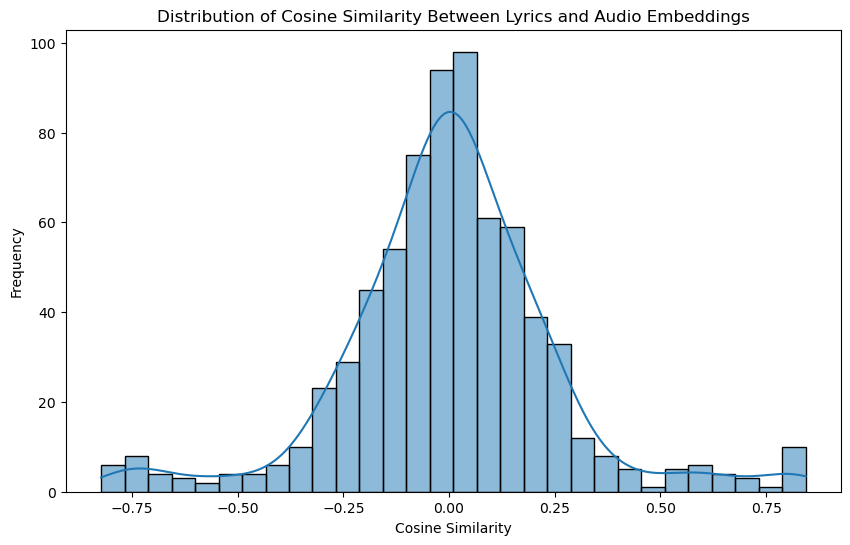

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\nCosine Similarity Statistics:")
print(merged_df['cosine_similarity'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['cosine_similarity'], bins=30, kde=True)
plt.title("Distribution of Cosine Similarity Between Lyrics and Audio Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()



Similarity Clusters Distribution:
similarity_cluster
2    244
5    177
1    145
0     89
3     30
4     27
Name: count, dtype: int64


/tmp/ipykernel_63804/1018299018.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='similarity_cluster', y='cosine_similarity', data=merged_df, palette="Set2")


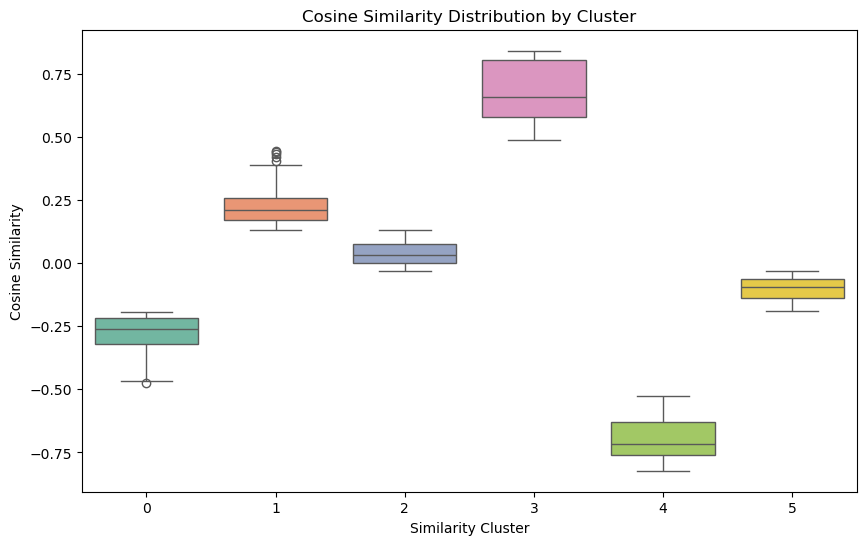

In [112]:
from sklearn.cluster import KMeans

k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
merged_df['similarity_cluster'] = kmeans.fit_predict(merged_df[['cosine_similarity']])

print("\nSimilarity Clusters Distribution:")
print(merged_df['similarity_cluster'].value_counts())

plt.figure(figsize=(10, 6))
sns.boxplot(x='similarity_cluster', y='cosine_similarity', data=merged_df, palette="Set2")
plt.title("Cosine Similarity Distribution by Cluster")
plt.xlabel("Similarity Cluster")
plt.ylabel("Cosine Similarity")
plt.show()


## From Emotion Classification

In [77]:
emotion_classifier = pipeline("text-classification", model="nateraw/bert-base-uncased-emotion", truncation=True, return_all_scores=True, max_length=512)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use cpu


In [78]:
def classify_emotions(file):
    path = "./Data/Useable_data/lyrics_cleaned/" + file + ".txt"
    with open(path, 'r') as f:
        text = f.read()
        
    results = emotion_classifier(text)
    emotion_scores = {item['label']: item['score'] for item in results[0]}
    return emotion_scores

print("\nClassifying emotions in lyrics...")
merged_df['lyrics_emotions'] = merged_df['audio_file'].apply(classify_emotions)
print(merged_df[['audio_file', 'lyrics_emotions']].head())


Classifying emotions in lyrics...
  audio_file                                    lyrics_emotions
0       1157  {'sadness': 0.03209918364882469, 'joy': 0.1427...
1       1157  {'sadness': 0.03209918364882469, 'joy': 0.1427...
2       1157  {'sadness': 0.03209918364882469, 'joy': 0.1427...
3       1157  {'sadness': 0.03209918364882469, 'joy': 0.1427...
4       1179  {'sadness': 0.19180260598659515, 'joy': 0.4947...


In [127]:
merged_df['lyrics_dominant_emotion'] = merged_df['lyrics_emotions'].apply(lambda emotion_dict: max(emotion_dict, key=emotion_dict.get))

print("\nLyrics Dominant Emotions:")
print(merged_df['lyrics_dominant_emotion'].value_counts())



Lyrics Dominant Emotions:
lyrics_dominant_emotion
joy         268
sadness     254
anger        98
fear         40
love         28
surprise     24
Name: count, dtype: int64


In [129]:
deam_annotations_path = "./Data/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv"
deam_annotations_path_2000 = "./Data/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv"

deam_df_200 = pd.read_csv(deam_annotations_path_2000)
deam_df = pd.read_csv(deam_annotations_path)

deam_df = pd.concat([deam_df_200, deam_df], ignore_index=True)

def normalize_scores(df, column):
    min_val = df[column].min()
    max_val = df[column].max()
    return (df[column] - min_val) / (max_val - min_val)

deam_df[' valence_norm'] = normalize_scores(deam_df, ' valence_mean')
deam_df[' arousal_norm'] = normalize_scores(deam_df, ' arousal_mean')

In [236]:
## These threshold assumptions were made as follow:
## High Arousal: Emotions that are intense, energetic, or activating.
##      Examples: Excitement, anger, fear, enthusiasm

## Low Arousal: Emotions that are calm, relaxed, or subdued.
##      Examples: Sadness, contentment, boredom, relaxation.

def map_to_emotion(valence_norm, arousal_norm):
    if valence_norm >= 0.66:
        if arousal_norm >= 0.66:
            return "surprise"
        elif arousal_norm >= 0.5:
            return "fear"
        else:
            return "love" 
    elif valence_norm >= 0.5:
        if arousal_norm >= 0.66:
            return "joy"
        elif arousal_norm >= 0.5:
            return "anger" 
        else:
            return "fear"
    else:
        if arousal_norm >= 0.5:
            return "sadness"
        elif arousal_norm >= 0.25:
            return "joy"
        else:
            return "love"



In [231]:
deam_df['emotion'] = deam_df.apply(
    lambda row: map_to_emotion(row[' valence_norm'], row[' arousal_norm']), axis=1
)

# Display the emotion distribution
print("\nEmotion Distribution:")
print(deam_df['emotion'].value_counts())



Emotion Distribution:
emotion
joy         609
sadness     280
love        273
fear        237
anger       208
surprise    195
Name: count, dtype: int64


In [232]:
deam_df['song_id'] = deam_df['song_id'].astype(str)
merged_df['audio_emotion'] = merged_df['audio_file'].map(deam_df.set_index('song_id')['emotion'])


In [233]:
merged_df.head()

,audio_file,artist,title,lyrics_embedding,audio_segment,embedding,audio_embedding_reduced,cosine_similarity,audio_embedding_common,text_embedding_common,similarity_cluster,lyrics_emotions,lyrics_dominant_emotion,audio_cluster,audio_emotion,emotion_aligned
0,1157,Eli Uno,Guilty Pleasure,"[-0.07346033, -0.066322036, 0.05177308, -0.000...",1157_segment0.wav,"[2.1990497, 1.9587492, 3.3925807, 2.5102823, 1...","[2.6270368355084783, -1.7168615727953134, 4.58...",0.031420,"[2.6270368355087084, -1.7168615728177277, 4.58...","[0.2407179009351312, -0.06577573916523011, -0....",2,"{'sadness': 0.03209918364882469, 'joy': 0.1427...",surprise,4,surprise,False
1,1157,Eli Uno,Guilty Pleasure,"[-0.07346033, -0.066322036, 0.05177308, -0.000...",1157_segment1.wav,"[2.2955348, 1.9615974, 3.4196806, 2.515034, 1....","[1.9860875731529752, -1.1034000938759478, 5.19...",-0.036969,"[1.986087573155253, -1.1034000939202955, 5.199...","[0.24071790093513115, -0.06577573916522998, -0...",5,"{'sadness': 0.03209918364882469, 'joy': 0.1427...",surprise,4,surprise,False
2,1157,Eli Uno,Guilty Pleasure,"[-0.07346033, -0.066322036, 0.05177308, -0.000...",1157_segment2.wav,"[2.0037982, 1.7714206, 3.7374218, 2.6960812, 1...","[3.2049754594598685, 0.35311745623056834, 5.64...",0.006341,"[3.2049754594535536, 0.3531174562109185, 5.644...","[0.24071790093513115, -0.06577573916523033, -0...",2,"{'sadness': 0.03209918364882469, 'joy': 0.1427...",surprise,4,surprise,False
3,1157,Eli Uno,Guilty Pleasure,"[-0.07346033, -0.066322036, 0.05177308, -0.000...",1157_segment3.wav,"[2.1527195, 1.9722733, 3.585451, 2.8843088, 1....","[3.130686275832047, 0.22807847751126983, 5.409...",-0.034520,"[3.1306862758256515, 0.22807847748012022, 5.40...","[0.240717900935131, -0.06577573916523066, -0.2...",5,"{'sadness': 0.03209918364882469, 'joy': 0.1427...",surprise,4,surprise,False
4,1179,Nyoy Volante,Bakit Ba Ganyan,"[-0.017653123, 0.050018955, 0.066763796, 0.009...",1179_segment0.wav,"[2.1918643, 1.9627427, 2.2738183, 1.4970484, 1...","[-8.176361325148035, -2.902925219966223, -0.35...",0.099624,"[-8.17636132513892, -2.902925219973164, -0.357...","[-0.21339193617737154, 0.2837990465792076, -0....",2,"{'sadness': 0.19180260598659515, 'joy': 0.4947...",joy,2,joy,False


# Results

In [234]:
audio_emotions = merged_df[['audio_file', 'audio_emotion']].rename(columns={'audio_emotion': 'audio_emotion_label'})
text_emotions = merged_df[['audio_file', 'lyrics_dominant_emotion']].rename(columns={'lyrics_dominant_emotion': 'text_emotion_label'})

# Merge the two emotion labels
emotion_comparison_df = pd.merge(audio_emotions, text_emotions, on='audio_file', how='inner')

emotion_comparison_df['emotion_aligned'] = emotion_comparison_df['audio_emotion_label'] == emotion_comparison_df['text_emotion_label']

# Calculate overall alignment percentage
alignment_percentage = emotion_comparison_df['emotion_aligned'].mean() * 100
print(f"Overall Emotion Alignment Percentage: {alignment_percentage:.2f}%")


Overall Emotion Alignment Percentage: 63.10%


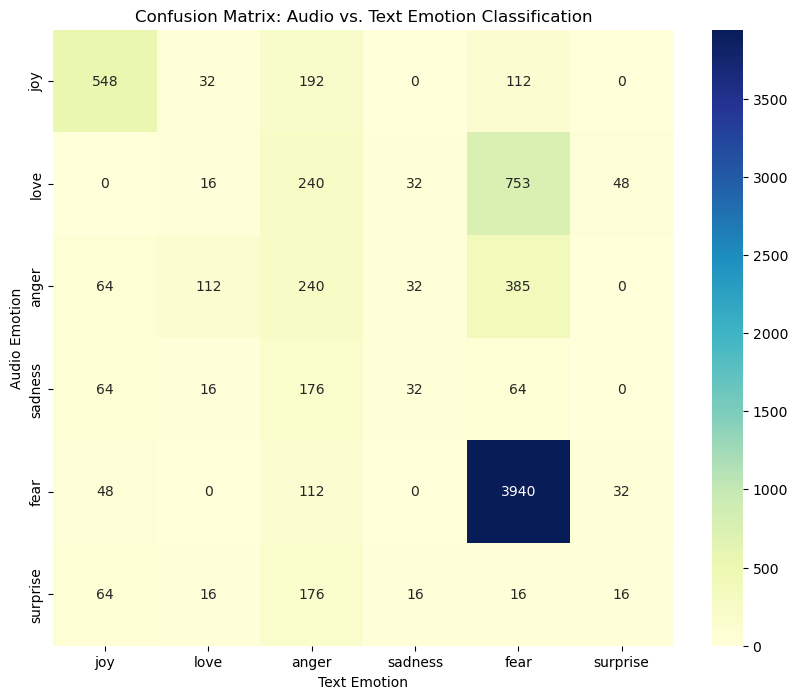

In [235]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(emotion_comparison_df['audio_emotion_label'], emotion_comparison_df['text_emotion_label'])

emotion_labels = ['joy', 'love', 'anger', 'sadness', 'fear', 'surprise']  

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Text Emotion')
plt.ylabel('Audio Emotion')
plt.title('Confusion Matrix: Audio vs. Text Emotion Classification')
plt.show()
